# Giving markov chains a try

In [138]:
import json
import csv
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import geopandas as gpd
import shapely
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon
from shapely.affinity import scale
import matplotlib.pyplot as plt
import glob
import os
import datetime

import markov_scripts as m
from sklearn.metrics import mean_squared_error

## Importing and processing data

In [201]:
#Reading data; creating training and test data
df = pd.read_csv('../data/AS_price_vol.csv')
df['year'] = pd.to_datetime(df['date']).dt.year

df_test = np.array(df.loc[df['year']==2018,'price_DAH_REGDN'])

In [203]:
#Manually dealing w major outliers
#df['price_DAH_REGDN'][df['price_DAH_REGDN']>100] = 100
data = np.array(df.loc[df['year']<2018,'price_DAH_REGDN']) #training

In [204]:
#Getting hourly average
hr_avg = df[['hr_beg','price_DAH_REGDN']].groupby('hr_beg').mean()['price_DAH_REGDN'].to_dict() #useful!
df['HourlyAvg'] = df['hr_beg'].map(hr_avg)
avgs = np.array(df.loc[df['year']==2018,'HourlyAvg'])

# Result for now: Markov model trained on 2008-2017 data predicting 2018 
(working to update to rolling prediction, which more realistic based on actual operations than full year at a time)
This is with "outliers" (ie, big price spikes) capped at $100

In [214]:
markovArray, cumMarkovArray, datMin, datMax, dmeshReal = m.MarkovChainFunction_24hrs(data,40)
datSim = m.MarkovSim_24hrs(df_test, cumMarkovArray, datMin, datMax, dmeshReal)

In [215]:
print(mean_squared_error(df_test, datSim))
print(mean_squared_error(df_test, avgs))

372.3685568167816
51.10986049320179


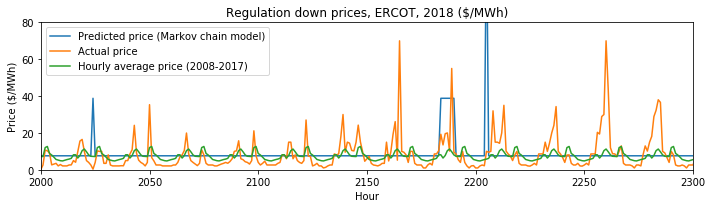

In [216]:
fig = plt.figure(figsize=(10,3))
plt.plot(datSim, label="Predicted price (Markov chain model)")
plt.plot(df_test, label="Actual price")
plt.plot(avgs, label="Hourly average price (2008-2017)")
plt.title("Regulation down prices, ERCOT, 2018 ($/MWh)")
plt.xlabel("Hour")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.xlim([2000,2300])
plt.ylim([0,80])
plt.tight_layout()

In [217]:
spiking = pd.DataFrame({"actual": df_test,
                       "simulated": datSim})
spiking['both spike'] = (df_test > spike) & (datSim > spike)
len(spiking[spiking['both spike']==True]) / sum(df_test > spike)

#spike prediction gets worse when >$100 are cut off, even though MSE improves

0.09642857142857143

## Cross-validation

In [210]:
#Cross-validated selection of number of bins to minimize MSE
bins = np.arange(5,150,5)

from sklearn.model_selection import TimeSeriesSplit

X = data
y = data
n = 5
fold = 0
tscv = TimeSeriesSplit(n_splits=n)
mses = np.zeros((n,len(bins)))

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] #y_train won't get used
    
    for i, bin_num in enumerate(bins):
        markovArray, cumMarkovArray, datMin, datMax, dmeshReal = m.MarkovChainFunction_24hrs(X_train,bin_num)
        y_hat = m.MarkovSim_24hrs(X_test, cumMarkovArray, datMin, datMax, dmeshReal)
        mses[fold, i] = mean_squared_error(y_test, y_hat)
    
    fold += 1

In [211]:
#Getting cross-validated bin number
average_mses = {}
for i in range(len(bins)):
    average_mses[bins[i]] = np.mean(mses[:,i])

min_mse_index = min(average_mses, key=average_mses.get)

(0, 600)

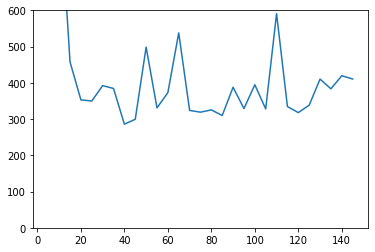

In [212]:
plt.plot(pd.DataFrame.from_dict(average_mses, orient='index'))
plt.ylim([0,600])

In [213]:
#Applying to actual test dataset (2018)
X_train = data
X_test = df_test #(only uses first value of the year to predict the whole year)
y_test = df_test
bin_num = min_mse_index

markovArray, cumMarkovArray, datMin, datMax, dmeshReal = m.MarkovChainFunction_24hrs(X_train,bin_num)
y_hat = m.MarkovSim_24hrs(X_test, cumMarkovArray, datMin, datMax, dmeshReal)
mean_squared_error(y_test, y_hat)

372.3685568167816

In [ ]:
#should we just start each new day afresh?
#or what if we used smoothed data? and checked out autocorrelation on that?
#DUDE NO we're not minimizing MSE, we're maximizing the number of price spikes we get!!!

## Cross-validating on spike prediction

In [364]:
def spike_accuracy(y_test, y_hat, spike):
    spiking = pd.DataFrame({"actual": y_test,
                           "simulated": y_hat})
    spiking['correctly predicted spike'] = (y_test > spike) & (y_hat > spike)
    spiking['correctly predicted (spike or not)'] = (y_test < spike) & (y_hat < spike) | (y_test > spike) & (y_hat > spike)
    
    correct_spikes = len(spiking[spiking['correctly predicted spike']==True]) / sum(y_test > spike)
    correct_overall = len(spiking[spiking['correctly predicted (spike or not)']==True]) / len(y_test)
    
    return correct_spikes, correct_overall

In [367]:
#Cross-validated selection of number of bins to maximize spike prediction!!
#"spike" is 1 SD above the mean--consider this
bins = np.arange(5,200,5)
spike = np.std(df['price_DAH_REGDN'])+np.mean(df['price_DAH_REGDN'])

from sklearn.model_selection import TimeSeriesSplit

X_train = data
y_train = data
n = 10
fold = 0
tscv = TimeSeriesSplit(n_splits=n)
spike_pred = np.zeros((n,len(bins)))
overall_pred = np.zeros((n,len(bins)))

for train_index, test_index in tscv.split(X):
    X_t, X_val = X_train[train_index], X_train[test_index]
    y_t, y_val = y_train[train_index], y_train[test_index] #y_train won't get used
    
    for i, bin_num in enumerate(bins):
        markovArray, cumMarkovArray, datMin, datMax, dmeshReal = m.MarkovChainFunction_24hrs(X_t,bin_num)
        y_hat = m.MarkovSim_24hrs(X_val, cumMarkovArray, datMin, datMax, dmeshReal)
        
        correct_spikes, correct_overall = spike_accuracy(y_val, y_hat, spike=spike)
        spike_pred[fold, i] = correct_spikes
        overall_pred[fold, i] = correct_overall
    
    fold += 1

In [389]:
#the fact that the first set is so good suggests to me that the rolling model will be great
#Could normalize by dividing error by standard deviation
def make_df(spike_pred):
    spikes = pd.DataFrame(spike_pred, columns=bins)
    spikes.loc['mean',:] = spikes.mean(axis=0)
    spikes.loc['std',:] = spikes.std(axis=0)
    spikes.loc['score',:] = spikes.loc['mean',:]/spikes.loc['std',:]
    avgscore = spikes.loc['score',:].replace([np.inf], np.nan).mean()
    spikes.loc['score_norm',:] = spikes.loc['score',:]/avgscore
    return spikes

In [390]:
spikes = make_df(spike_pred)
correct = make_df(overall_pred)
real_score = correct.loc['score_norm',:] + spikes.loc['score_norm',:]

In [397]:
max_spike_index = real_score[10:].idxmax()
max_spike_index

180

In [398]:
#Applying to actual test dataset (2018)
X_train = data
X_test = df_test #(only uses first value of the year to predict the whole year)
y_test = df_test
bin_num = max_spike_index

markovArray, cumMarkovArray, datMin, datMax, dmeshReal = m.MarkovChainFunction_24hrs(X_train,bin_num)
y_hat = m.MarkovSim_24hrs(X_test, cumMarkovArray, datMin, datMax, dmeshReal)
correct_spikes, correct_overall = spike_accuracy(y_test, y_hat, spike=spike)
print(correct_spikes)
print(correct_overall)

0.18571428571428572
0.7562172028291125


# Rolling model

In [471]:
list(data[:-lag]).extend(list(df_test)) #trying to get for 2018

TypeError: object of type 'NoneType' has no len()

In [476]:
#testing with first part of dataset: use 6 months of data to predict 2 days
lag = 180*24
y_test_list = []
y_hat_list = []

for i in range(180):
    X_train = data[i*48 : lag+i*48]
    y_train = data[i*48 : lag+i*48]
    X_test = data[lag+i*48:lag+(i+1)*48]
    y_test = data[lag+i*48:lag+(i+1)*48]

    bins = np.arange(5,75,5)
    spike = np.std(X_train)+np.mean(X_train)
#    spike = np.std(df['price_DAH_REGDN'])+np.mean(df['price_DAH_REGDN']) #should this change progressively?

    n = 5
    fold = 0
    tscv = TimeSeriesSplit(n_splits=n)
    spike_pred = np.zeros((n,len(bins)))
    overall_pred = np.zeros((n,len(bins)))

    for train_index, test_index in tscv.split(X_train):
        X_t, X_val = X_train[train_index], X_train[test_index]
        y_t, y_val = y_train[train_index], y_train[test_index] #y_train won't get used

        for i, bin_num in enumerate(bins):
            markovArray, cumMarkovArray, datMin, datMax, dmeshReal = m.MarkovChainFunction_24hrs(X_t,bin_num)
            y_hat = m.MarkovSim_24hrs(X_val, cumMarkovArray, datMin, datMax, dmeshReal)

            correct_spikes, correct_overall = spike_accuracy(y_val, y_hat, spike=spike)
            spike_pred[fold, i] = correct_spikes
            overall_pred[fold, i] = correct_overall

        fold += 1

    spikes = make_df(spike_pred)
    correct = make_df(overall_pred)
    real_score = correct.loc['score_norm',:] + spikes.loc['score_norm',:]

    max_spike_index = real_score[1:].idxmax() #cutting out 5
    max_spike_index

    bin_num = max_spike_index
    print(bin_num)

    markovArray, cumMarkovArray, datMin, datMax, dmeshReal = m.MarkovChainFunction_24hrs(X_train,bin_num)
    y_hat = m.MarkovSim_24hrs(X_test, cumMarkovArray, datMin, datMax, dmeshReal, rand_seed=None)

    y_test_list.extend(y_test)
    y_hat_list.extend(y_hat)

45
25
35
15
40
20
20
30
25
15
60
55
60
60
50
10
70
10
15
15
65
50
55
25
70
50
70
20
10
55
40
10
10
35
55
65
45
70
20
45
70
65
70
35
45
45
70
20
45
15
35
30
35
35
45
70
70
40
40
70
70
40
70
10
40
40
30
25
25
35
65
65
10
10
45
55
35
35
10
35
35
55
45
50
45
60
10
70
30
15
15
25
70
40
30
40
35
15
10
10
15
10
10
35
15
10
15
15
10
55
15
55
50
35
65
40
15
15
15
15
15
40
40
60
30
30
30
35
60
35
15
15
65
35
35
30
25
20
65
70
40
35
60
40
40
40
50
25
25
70
70
15
20
25
25
25
25
45
25
25
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


Really gotta check for cols where avg is > spike

In [477]:
y_test_list = np.array(y_test_list)
y_hat_list = np.array(y_hat_list)
correct_spikes, correct_overall = spike_accuracy(y_test_list, y_hat_list, spike=spike)
print(correct_spikes)
print(correct_overall)

0.7368421052631579
0.3392361111111111


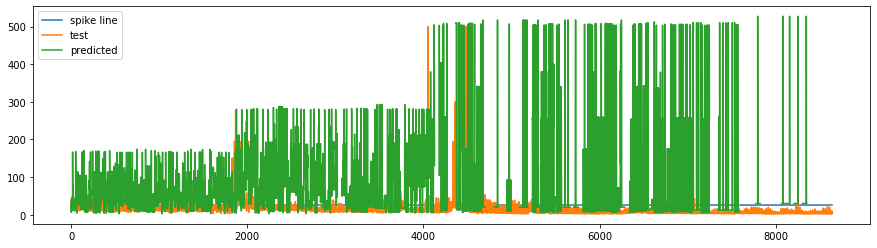

In [484]:
fig = plt.figure(figsize=(15,4))
plt.plot([spike]*len(y_test_list), label="spike line")
plt.plot(y_test_list, label="test")
plt.plot(y_hat_list, label="predicted")
plt.legend()
#seems to break at the end...cehck it out

In [475]:
spike

25.599342389172428